starting...
loading data,please wait a moment...
Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
D:\Data Minning\train_code\train\Autoencoder
D:\Data Minning\train_code\train\Autoencoder\result
D:\Data Minning\train_code\train\Autoencoder\result
Epoch: 0001 cost = 19362.435976136
Epoch: 0002 cost = 11615.113110227
Total cost is: 975660.0
weights is: <bound method AdditiveGaussianNoiseAutoencoder.get_weights of <AGN_Autoencoder.AdditiveGaussianNoiseAutoencoder object at 0x000000000D1475C0>>
bias is: <bound method AdditiveGaussianNoiseAutoencoder.get_biases of <AGN_Autoencoder.AdditiveGaussianNoiseAutoencoder object at 0x000000000D1475C0>>
(128, 784)
recontruct result is: [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0

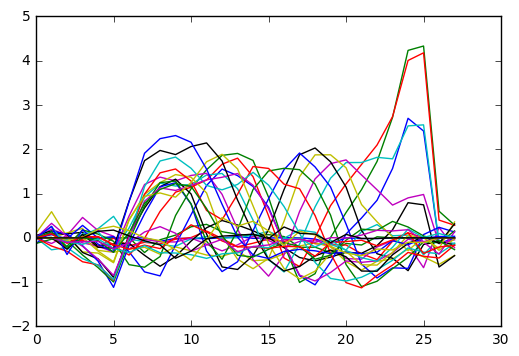

ending...


In [1]:
from CLASS.AGN_Autoencoder import *
from CLASS.MNA_Autoencoder import *
from CLASS.VAE_Autoencoder import *

def main(name = None):
    if name == 'AGN':
        AGN_main()
    elif name == 'MNA':
        MNA_main()
    elif name == 'VAE':
        VAE_main()
    else:
        print('You should choose from the AGN MNA or VAE,please check it.')
        raise Exception('Error...')
        
if __name__ == '__main__':
    main('AGN')
    #main('MNA')
    #main('VAE')

In [ ]:
# import the packages
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import numpy as np
import tensorflow as tf
import sklearn.preprocessing as prep

from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
from scipy.misc import imsave

def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),
                              minval = low,
                              maxval = high,
                              dtype = tf.float32,
                              seed = 33)

class AdditiveGaussianNoiseAutoencoder(object):
    def __init__(self, n_input, n_hidden, transfer_function = tf.nn.softplus, 
                 optimizer = tf.train.AdamOptimizer(), scale = 0.1):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.scale = tf.placeholder(tf.float32)
        self.training_scale = scale
        network_weights = self._initial_weights()
        self.weights = network_weights
        
        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.hidden = self.transfer(tf.add(tf.matmul(self.x + scale * tf.random_normal((n_input,)),
                                                     self.weights['w1']), self.weights['b1']))
        self.reconstruction = tf.add(tf.matmul(self.hidden, self.weights['w2']), self.weights['b2'])
        
        # cost 
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)
        
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)
        
    def _initial_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.Variable(xavier_init(self.n_input, self.n_hidden))
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype = tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype = tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype = tf.float32))
        return all_weights
    
    def once_fit(self, X):
        cost, _ = self.sess.run((self.cost, self.optimizer), feed_dict = {self.x: X, self.scale: self.training_scale})
        return cost
    
    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X, self.scale: self.training_scale})
    
    def transform(self, X):
        return self.sess.run(self.hidden, feed_dict = {self.x: X, self.scale: self.training_scale})
    
    def generate(self, hidden = None):
        if hidden is None:
            hidden = np.random.normal(size = self.weights['b1'])
        return self.sess.run(self.reconstruction, feed_dict = {self.hidden: hidden})
    
    def reconstraion(self, X):
        return self.sess.run(self.reconstruction, feed_dict = {self.x: X, self.scale: self.training_scale})
    
    def get_weights(self):
        return self.sess.run(self.weights['w1'])
    
    def get_biases(self):
        return self.sess.run(self.weights['b1'])
    
def AGN_main():
    print('starting...')
    print('loding ')
    mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

    def standard_scale(X_train, X_test):
        preprocess = prep.StandardScaler().fit(X_train)
        X_train = preprocess.transform(X_train)
        X_test = preprocess.transform(X_test)
        return X_train, X_test

    def get_batch_data(data, batch_size):
        start_index = np.random.randint(0, len(data) - batch_size)
        return data[start_index : start_index + batch_size]


    X_train, X_test = standard_scale(mnist.train.images, mnist.test.images)

    n_samples = int(mnist.train.num_examples)
    nb_epoch = 2
    batch_size = 128
    display_time = 1

    autoencoder = AdditiveGaussianNoiseAutoencoder(n_input = 784,
                                                   n_hidden = 200,
                                                   transfer_function = tf.nn.relu,
                                                   optimizer = tf.train.AdamOptimizer(learning_rate = 0.001),
                                                   scale = 0.01)

    if os.path.exists(os.path.dirname('result')):
        os.rename('result','result_before')
        os.mkdir('result')
        path = os.getcwd()
        print(path)
        paths = path + str('\\result')
        print(paths)
        os.chdir(paths)
        print(os.getcwd())
    else:
        os.mkdir('result')
        path = os.getcwd()
        print(path)
        paths = path + str('\\result')
        print(paths)
        os.chdir(paths)
        print(os.getcwd())

    for epoch in range(nb_epoch):
        total_batch = int(n_samples / batch_size)
        avg_cost = 0.
        for i in range(total_batch):
            batch_data = get_batch_data(X_train, batch_size)
            cost = autoencoder.once_fit(batch_data)
            avg_cost += cost / n_samples * batch_size
            weights = autoencoder.get_weights
            bias = autoencoder.get_biases
            reconstract = autoencoder.reconstraion(batch_data) 
            picture = np.reshape(reconstract, [128, 28, 28, -1])
            #print(picture.shape)
            result = picture[1:2]
            #print(result.shape)
            data = np.reshape(result, [28, 28])
            imsave('%d.jpg' %(i), data)
        
        if epoch % display_time == 0:
            print('Epoch:', '%04d' %(epoch + 1), 'cost =','{:.9f}'.format(avg_cost))
    print('Total cost is: ' + str(autoencoder.calc_total_cost(X_test)))
    print('weights is:', weights)
    print('bias is:', bias)
    print(reconstract.shape)
    print('recontruct result is:', reconstract)
    plt.plot(data)
    plt.show() 
    print('ending...')
    
if __name__ == '__main__':
    AGN_main()

In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import os
import tensorflow as tf
import numpy as np
import sklearn.preprocessing as prep

from matplotlib import pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from scipy.misc import imsave

def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),
                              minval = low,
                              maxval = high,
                              dtype = tf.float32,
                              seed = 33)

class MaskingNoiseAutoencoder(object):
    def __init__(self, n_input, n_hidden, transfer_function = tf.nn.softplus, optimizer = tf.train.AdamOptimizer(),
                 dropout_probability = 0.95):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.dropout_probability = dropout_probability
        self.keep_prob = tf.placeholder(tf.float32)

        network_weights = self._initialize_weights()
        self.weights = network_weights

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.hidden = self.transfer(tf.add(tf.matmul(tf.nn.dropout(self.x, self.keep_prob), self.weights['w1']),
                                           self.weights['b1']))
        self.reconstruction = tf.add(tf.matmul(self.hidden, self.weights['w2']), self.weights['b2'])

        # cost
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.Variable(xavier_init(self.n_input, self.n_hidden))
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype = tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype = tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype = tf.float32))
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer),
                                  feed_dict = {self.x: X, self.keep_prob: self.dropout_probability})
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X, self.keep_prob: 1.0})

    def transform(self, X):
        return self.sess.run(self.hidden, feed_dict = {self.x: X, self.keep_prob: 1.0})

    def generate(self, hidden = None):
        if hidden is None:
            hidden = np.random.normal(size = self.weights["b1"])
        return self.sess.run(self.reconstruction, feed_dict = {self.hidden: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict = {self.x: X, self.keep_prob: 1.0})

    def getWeights(self):
        return self.sess.run(self.weights['w1'])

    def getBiases(self):
        return self.sess.run(self.weights['b1'])
    
# define the main function
def MNA_main():
    print('starting...')
    print('loading data,please wait a moment...')
    mnist = input_data.read_data_sets('MNIST_data', one_hot = True)
    
    n_samples = int(mnist.train.num_examples)
    training_epochs = 200
    batch_size = 128
    display_step = 1

    def standard_scale(X_train, X_test):
        preprocessor = prep.StandardScaler().fit(X_train)
        X_train = preprocessor.transform(X_train)
        X_test = preprocessor.transform(X_test)
        return X_train, X_test

    def get_random_block_from_data(data, batch_size):
        start_index = np.random.randint(0, len(data) - batch_size)
        return data[start_index:(start_index + batch_size)]

    X_train, X_test = standard_scale(mnist.train.images, mnist.test.images)

    autoencoder = MaskingNoiseAutoencoder(n_input = 784,
                                          n_hidden = 200,
                                          transfer_function = tf.nn.softplus,
                                          optimizer = tf.train.AdamOptimizer(learning_rate = 0.001),
                                          dropout_probability = 0.95)
    
    if os.path.exists('result_MNA'):
        os.rename('result_MNA','result_MNA_before')
        os.mkdir('result_MNA')   
        path = os.getcwd()
        print(path)
        paths = path + str('\\result_MNA')
        print(paths)
        os.chdir(paths)
        print(os.getcwd())
    else:
        os.mkdir('result_MNA')   
        path = os.getcwd()
        print(path)
        paths = path + str('\\result_MNA')
        print(paths)
        os.chdir(paths)
        print(os.getcwd())
    
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        for i in range(total_batch):
            batch_xs = get_random_block_from_data(X_train, batch_size)
            cost = autoencoder.partial_fit(batch_xs)
            avg_cost += cost / n_samples * batch_size
            weights = autoencoder.getWeights
            bias = autoencoder.getBiases
            #data.append(batch_data)
            reconstract = autoencoder.reconstruct(batch_xs) 
            picture = np.reshape(reconstract, [128, 28, 28, -1])
            #print(picture.shape)
            result = picture[1:2]
            #print(result.shape)
            data = np.reshape(result, [28, 28])
            imsave('%d.jpg' %(i), data)
        
        if epoch % display_step == 0:
            print ("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(avg_cost))

    print ("Total cost: " + str(autoencoder.calc_total_cost(X_test)))
    print('weights is:', weights)
    print('bias is:', bias)
    print(reconstract.shape)
    print('recontruct result is:', reconstract)
    plt.plot(data)
    plt.show()
    print('ending...')

if __name__ == '__main__':
    MNA_main()


You should choose from the AGN MNA or VAE,please check it.


Exception: Error...

starting...
loading data,please wait moment...
Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
D:\Data Minning\train_code\train\Autoencoder
D:\Data Minning\train_code\train\Autoencoder\result_VAE
D:\Data Minning\train_code\train\Autoencoder\result_VAE
Epoch: 0001 cost= 1119.167525568
Epoch: 0002 cost= 659.921910227
Epoch: 0003 cost= 594.457267756
Epoch: 0004 cost= 570.278955682
Epoch: 0005 cost= 554.892253338
Epoch: 0006 cost= 545.335611577
Epoch: 0007 cost= 537.892170881
Epoch: 0008 cost= 531.432192827
Epoch: 0009 cost= 526.244443253
Epoch: 0010 cost= 519.739064631
Epoch: 0011 cost= 516.690627415
Epoch: 0012 cost= 512.236549716
Epoch: 0013 cost= 508.422539276
Epoch: 0014 cost= 505.109449716
Epoch: 0015 cost= 500.568265057
Epoch: 0016 cost= 497.157010511
Epoch: 0017 cost= 495.665002841
Epoch: 0018 cost= 491.773673722
Epoch: 0019 cost= 490.359

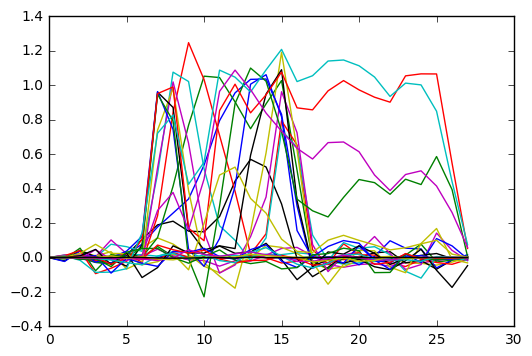

ending...


In [2]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import os
import tensorflow as tf
import numpy as np
import sklearn.preprocessing as prep

from matplotlib import pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from scipy.misc import imsave

def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),
                              minval = low,
                              maxval = high,
                              dtype = tf.float32,
                              seed = 33)

class VariationalAutoencoder(object):

    def __init__(self, n_input, n_hidden, optimizer = tf.train.AdamOptimizer()):
        self.n_input = n_input
        self.n_hidden = n_hidden

        network_weights = self._initialize_weights()
        self.weights = network_weights

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.z_mean = tf.add(tf.matmul(self.x, self.weights['w1']), self.weights['b1'])
        self.z_log_sigma_sq = tf.add(tf.matmul(self.x, self.weights['log_sigma_w1']), self.weights['log_sigma_b1'])

        # sample from gaussian distribution
        eps = tf.random_normal(tf.stack([tf.shape(self.x)[0], self.n_hidden]), 0, 1, dtype = tf.float32)
        self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        self.reconstruction = tf.add(tf.matmul(self.z, self.weights['w2']), self.weights['b2'])

        # cost
        reconstr_loss = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq
                                           - tf.square(self.z_mean)
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)
        self.optimizer = optimizer.minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.Variable(xavier_init(self.n_input, self.n_hidden))
        all_weights['log_sigma_w1'] = tf.Variable(xavier_init(self.n_input, self.n_hidden))
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype=tf.float32))
        all_weights['log_sigma_b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype=tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype=tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype=tf.float32))
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X})

    def transform(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, hidden = None):
        if hidden is None:
            hidden = np.random.normal(size=self.weights["b1"])
        return self.sess.run(self.reconstruction, feed_dict={self.z_mean: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict={self.x: X})

    def getWeights(self):
        return self.sess.run(self.weights['w1'])

    def getBiases(self):
        return self.sess.run(self.weights['b1'])

def VAE_main():
    print('starting...')
    print('loading data,please wait moment...')
    mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

    def min_max_scale(X_train, X_test):
        preprocessor = prep.MinMaxScaler().fit(X_train)
        X_train = preprocessor.transform(X_train)
        X_test = preprocessor.transform(X_test)
        return X_train, X_test


    def get_random_block_from_data(data, batch_size):
        start_index = np.random.randint(0, len(data) - batch_size)
        return data[start_index:(start_index + batch_size)]


    X_train, X_test = min_max_scale(mnist.train.images, mnist.test.images)

    n_samples = int(mnist.train.num_examples)
    training_epochs = 20
    batch_size = 128
    display_step = 1

    autoencoder = VariationalAutoencoder(n_input = 784,
                                         n_hidden = 200,
                                         optimizer = tf.train.AdamOptimizer(learning_rate = 0.001))

    if os.path.exists('result_VAE'):
        os.rename('result_VAE','result_VAE_before')
        path = os.getcwd()
        print(path)
        paths = path + str('\\result_VAE')
        print(paths)
        os.chdir(paths)
        print(os.getcwd())
    else:
        os.mkdir('result_VAE')
        path = os.getcwd()
        print(path)
        paths = path + str('\\result_VAE')
        print(paths)
        os.chdir(paths)
        print(os.getcwd())


    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs = get_random_block_from_data(X_train, batch_size)

            # Fit training using batch data
            cost = autoencoder.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size
            weights = autoencoder.getWeights
            bias = autoencoder.getBiases
            #data.append(batch_data)
            reconstract = autoencoder.reconstruct(batch_xs) 
            picture = np.reshape(reconstract, [128, 28, 28, -1])
            #print(picture.shape)
            result = picture[1:2]
            #print(result.shape)
            data = np.reshape(result, [28, 28])
            imsave('%d.jpg' %(i), data)

        # Display logs per epoch step
        if epoch % display_step == 0:
            print ("Epoch:", '%04d' % (epoch + 1),  "cost=", "{:.9f}".format(avg_cost))

    print ("Total cost: " + str(autoencoder.calc_total_cost(X_test)))
    print('weights is:', weights)
    print('bias is:', bias)
    print(reconstract.shape)
    print('recontruct result is:', reconstract)
    plt.plot(data)
    plt.show()  
    print('ending...')

if __name__ == '__main__':
    VAE_main()

In [ ]:
from AGN_Autoencoder import *
from MNA_Autoencoder import *
from VAE_Autoencoder import *

def main(name = None):
    if name == 'AGN':
        AGN_main()
    elif name == 'MNA':
        MNA_main()
    elif name == 'VAE':
        VAE_main()
    else:
        print('You should choose from the AGN MNA or VAE,please check it.')
        raise Exception('Error...')
        
if __name__ == '__main__':
    #main('AGN')
    #main('MNA')
    #main('VAE')
    main('TEST')